# To do
* Detrend Forcing data 
    * Remove overall trend
    * Remove seasonal trend


## Load packages

In [39]:
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
import statsmodels.api as sm

## Load in current forcing data

In [8]:
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

## Some testing

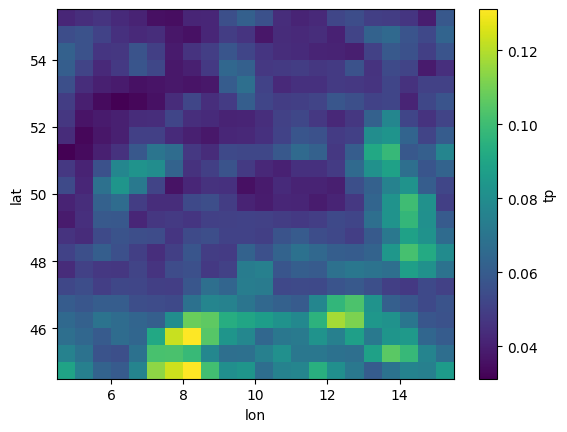

In [12]:
P_data.max(dim='time').plot()

In [23]:
# Function to calculate yearly mean for each pixel
def calculate_yearly_mean(data):
    yearly_mean = data.groupby('time.year').mean(dim='time')
    return yearly_mean

# Calculate yearly mean for each dataset
yearly_mean_P_data = calculate_yearly_mean(P_data)
yearly_mean_R_data = calculate_yearly_mean(R_data)
yearly_mean_T_data = calculate_yearly_mean(T_data)
yearly_mean_lai_data = calculate_yearly_mean(lai_data)

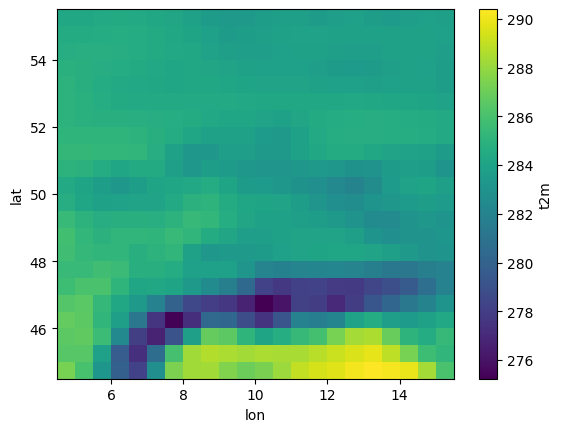

In [27]:
yearly_mean_T_data.max(dim='year').plot()

In [31]:
# overall trend over domain
mean_temperature_overall = yearly_mean_T_data.mean(dim=('lat', 'lon'))

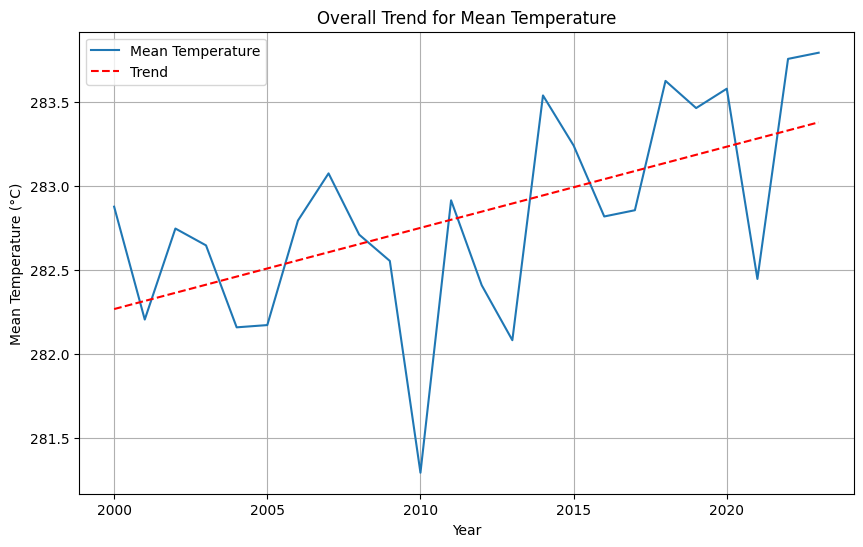

In [32]:
X = np.arange(len(mean_temperature_overall.year)).reshape(-1, 1)
y = mean_temperature_overall.values

# Fit linear regression model
model = LinearRegression().fit(X, y)
trend = model.predict(X)

# Plot overall trend
plt.figure(figsize=(10, 6))
plt.plot(mean_temperature_overall.year, mean_temperature_overall, label='Mean Temperature')
plt.plot(mean_temperature_overall.year, trend, label='Trend', linestyle='--', color='red')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.title('Overall Trend for Mean Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Calculate yearly mean for precipitation and radiation datasets
yearly_mean_P_data = calculate_yearly_mean(P_data)
yearly_mean_R_data = calculate_yearly_mean(R_data)

# Calculate mean over all pixels for each year
mean_precipitation_overall = yearly_mean_P_data.mean(dim=('lat', 'lon'))
mean_radiation_overall = yearly_mean_R_data.mean(dim=('lat', 'lon'))

# Fit linear regression model for precipitation
X_precipitation = np.arange(len(mean_precipitation_overall.year)).reshape(-1, 1)
y_precipitation = mean_precipitation_overall.values
model_precipitation = LinearRegression().fit(X_precipitation, y_precipitation)
trend_precipitation = model_precipitation.predict(X_precipitation)

# Fit linear regression model for radiation
X_radiation = np.arange(len(mean_radiation_overall.year)).reshape(-1, 1)
y_radiation = mean_radiation_overall.values
model_radiation = LinearRegression().fit(X_radiation, y_radiation)
trend_radiation = model_radiation.predict(X_radiation)

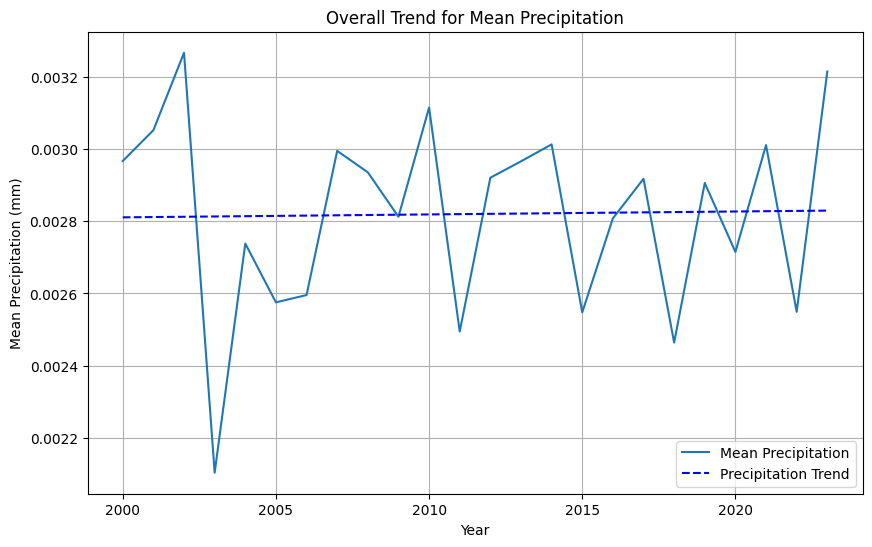

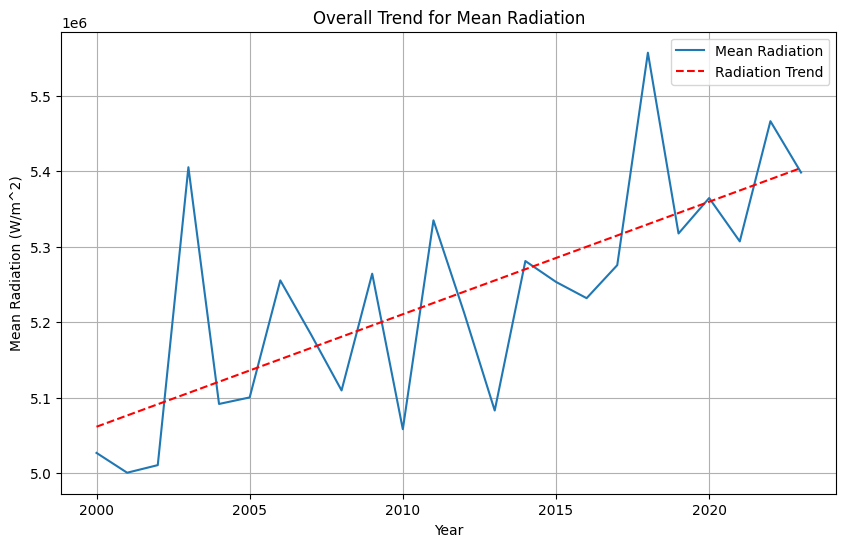

In [35]:
# Plot overall trend for precipitation
plt.figure(figsize=(10, 6))

plt.plot(mean_precipitation_overall.year, mean_precipitation_overall, label='Mean Precipitation')
plt.plot(mean_precipitation_overall.year, trend_precipitation, label='Precipitation Trend', linestyle='--', color='blue')

plt.xlabel('Year')
plt.ylabel('Mean Precipitation (mm)')
plt.title('Overall Trend for Mean Precipitation')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall trend for radiation
plt.figure(figsize=(10, 6))

plt.plot(mean_radiation_overall.year, mean_radiation_overall, label='Mean Radiation')
plt.plot(mean_radiation_overall.year, trend_radiation, label='Radiation Trend', linestyle='--', color='red')

plt.xlabel('Year')
plt.ylabel('Mean Radiation (W/m^2)')
plt.title('Overall Trend for Mean Radiation')
plt.legend()
plt.grid(True)
plt.show()


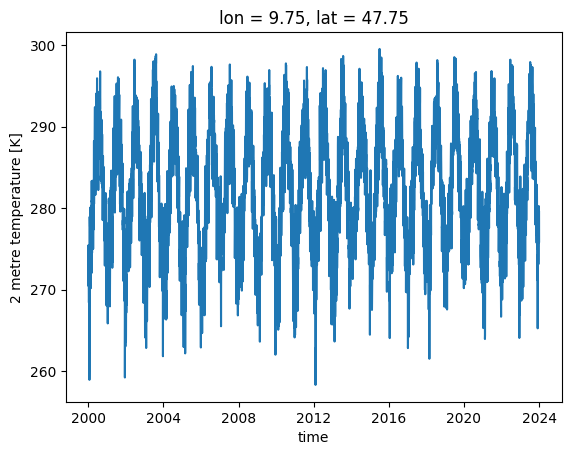

In [37]:
T_data[:, 15, 10].plot()

## Detrending data
Question: Which method do we chose?
- linear? --> probably works for temperature

### Temperature

#### Long-term trend

In [68]:
# Convert temperature data to numpy array
temperature_array = T_data.values

# Reshape the data into 2D array (time, flattened spatial dimensions)
time_length = len(T_data.time)
spatial_dims = T_data.shape[1:]
temperature_2d = temperature_array.reshape((time_length, -1))

# Detrend the data while preserving seasonal trend
detrended_temperature = detrend(temperature_2d, axis=0, type='linear')

# Reshape detrended data back to its original shape
detrended_temperature_data = xr.DataArray(detrended_temperature.reshape((time_length,) + spatial_dims),
                                          coords=T_data.coords, dims=T_data.dims)

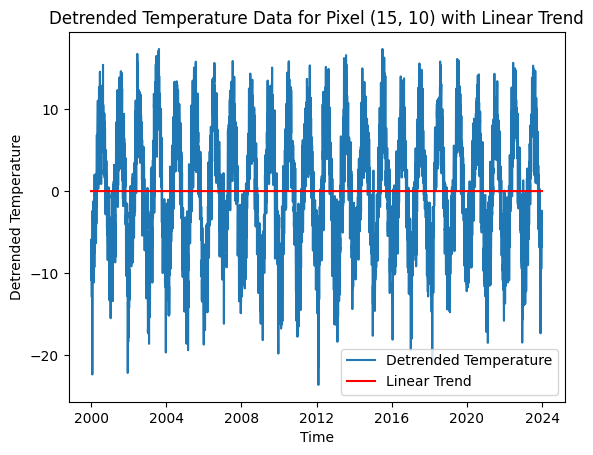

In [70]:
# Fit linear regression model to detrended temperature data for the pixel (15, 10)
detrended_temperature_pixel = detrended_temperature_data[:, 15, 10].values
time_values = detrended_temperature_data.time.values.astype(np.int64) // 10**9  # Convert time to Unix timestamp
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), detrended_temperature_pixel.reshape(-1, 1))

# Predict trend using the fitted model
trend = model.predict(time_values.reshape(-1, 1))

# Plot detrended temperature data for the pixel (15, 10)
detrended_temperature_data[:, 15, 10].plot(label='Detrended Temperature')

# Plot linear trend line for the pixel (15, 10)
plt.plot(detrended_temperature_data.time.values, trend, color='red', label='Linear Trend')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Detrended Temperature')
plt.title('Detrended Temperature Data for Pixel (15, 10) with Linear Trend')
plt.legend()

# Show the plot
plt.show()


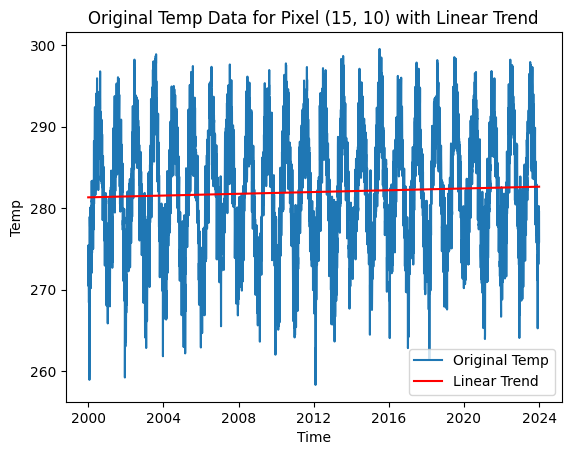

In [108]:
# Fit linear regression model to original radiation data for the pixel (15, 10)
original_temp_pixel = T_data[:, 15, 10].values
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), original_temp_pixel.reshape(-1, 1))

# Predict trend using the fitted model
trend = model.predict(time_values.reshape(-1, 1))

# Plot original radiation data for the pixel (15, 10)
T_data[:, 15, 10].plot(label='Original Temp')

# Plot linear trend line for the pixel (15, 10)
plt.plot(T_data.time.values, trend, color='red', label='Linear Trend')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Temp')
plt.title('Original Temp Data for Pixel (15, 10) with Linear Trend')
plt.legend()

# Show the plot
plt.show()


array([[281.32700277],
       [281.32715161],
       [281.32730045],
       ...,
       [282.63127756],
       [282.6314264 ],
       [282.63157524]])

#### Seasonal Trend

I don't think this makes too much sense, we can also just look at the different seasons.

In [95]:
# Initialize an empty array to store detrended temperature data
noseason_temp_data = []

# Iterate over each grid cell
for lat in range(len(T_data.lat)):
    for lon in range(len(T_data.lon)):
        # Extract temperature data for the current grid cell
        temperature_series = T_data[:, lat, lon]
        
        # Perform seasonal decomposition
        seasonal_decomposition = sm.tsa.seasonal_decompose(temperature_series, model='additive', period=365)
        
        # Extract the seasonal component
        seasonal_component = seasonal_decomposition.seasonal
        
        # Remove the seasonal component from the original data
        no_season_series = temperature_series - seasonal_component
        
        # Append detrended temperature data for the current grid cell to the list
        noseason_temp_data.append(no_season_series)

# Convert the list of detrended temperature data to an xarray DataArray
noseason_temp_data = xr.concat(noseason_temp_data, dim='location')

### Radiation

In [71]:
# Convert radiation data to numpy array
radiation_array = R_data.values

# Reshape the data into 2D array (time, flattened spatial dimensions)
time_length_rad = len(R_data.time)
spatial_dims_rad = R_data.shape[1:]
radiation_2d = radiation_array.reshape((time_length_rad, -1))

# Detrend the data while preserving seasonal trend
detrended_radiation = detrend(radiation_2d, axis=0, type='linear')

# Reshape detrended data back to its original shape
detrended_radiation_data = xr.DataArray(detrended_radiation.reshape((time_length_rad,) + spatial_dims_rad),
                                        coords=R_data.coords, dims=R_data.dims)


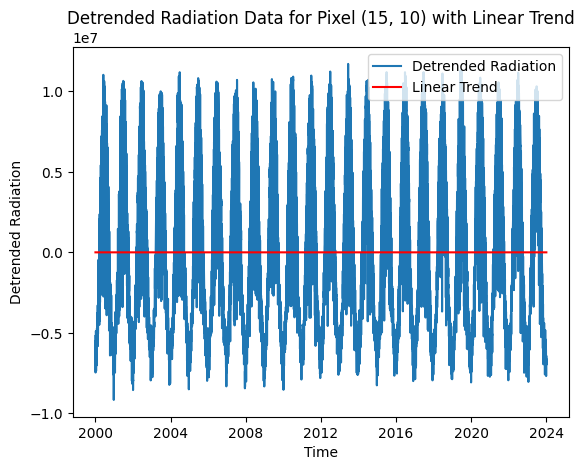

In [77]:
# Fit linear regression model to detrended temperature data for the pixel (15, 10)
detrended_radiation_pixel = detrended_radiation_data[:, 15, 10].values
time_values = detrended_radiation_data.time.values.astype(np.int64) // 10**9  # Convert time to Unix timestamp
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), detrended_radiation_pixel.reshape(-1, 1))

# Predict trend using the fitted model
trend = model.predict(time_values.reshape(-1, 1))

# Plot detrended temperature data for the pixel (15, 10)
detrended_radiation_data[:, 15, 10].plot(label='Detrended Radiation')

# Plot linear trend line for the pixel (15, 10)
plt.plot(detrended_radiation_data.time.values, trend, color='red', label='Linear Trend')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Detrended Radiation')
plt.title('Detrended Radiation Data for Pixel (15, 10) with Linear Trend')
plt.legend()

# Show the plot
plt.show()


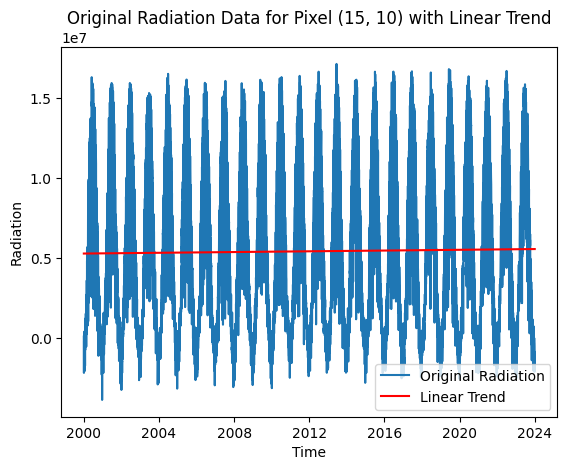

In [107]:
# Fit linear regression model to original radiation data for the pixel (15, 10)
original_radiation_pixel = R_data[:, 15, 10].values
model = LinearRegression()
model.fit(time_values.reshape(-1, 1), original_radiation_pixel.reshape(-1, 1))

# Predict trend using the fitted model
trend = model.predict(time_values.reshape(-1, 1))

# Plot original radiation data for the pixel (15, 10)
R_data[:, 15, 10].plot(label='Original Radiation')

# Plot linear trend line for the pixel (15, 10)
plt.plot(R_data.time.values, trend, color='red', label='Linear Trend')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Radiation')
plt.title('Original Radiation Data for Pixel (15, 10) with Linear Trend')
plt.legend()

# Show the plot
plt.show()


### LAI - has NaNs...

In [91]:
# Convert LAI data to numpy array
lai_array = lai_data.values

# Reshape the data into 2D array (time, flattened spatial dimensions)
time_length_lai = len(lai_data.time)
spatial_dims_lai = lai_data.shape[1:]
lai_2d = lai_array.reshape((time_length_lai, -1))

# Detrend the data while preserving seasonal trend
detrended_lai = np.apply_along_axis(lambda x: detrend(x, type='linear'), axis=0, arr=lai_2d)

# Reshape detrended data back to its original shape
detrended_lai_data = xr.DataArray(detrended_lai.reshape((time_length_lai,) + spatial_dims_lai),
                                  coords=lai_data.coords, dims=lai_data.dims)

ValueError: array must not contain infs or NaNs

### Precipitation - maybe not 

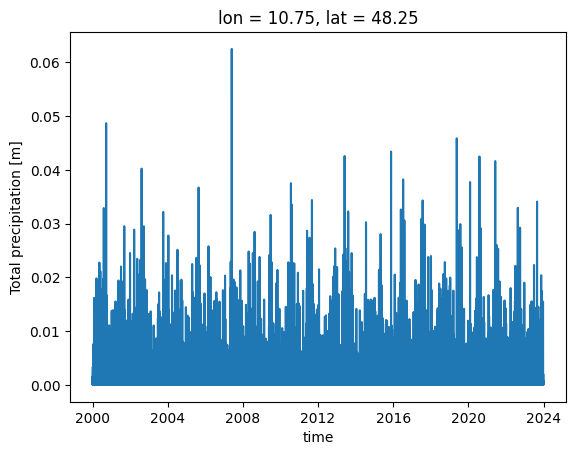

In [89]:
P_data[:, 14, 12].plot()

In [88]:
P_data

<xarray.DataArray 'tp' (time: 8766, lat: 22, lon: 22)> Size: 34MB
array([[[3.46481823e-03, 3.52501881e-03, 3.56233120e-03, ...,
         4.17888165e-03, 4.38153755e-03, 4.28330898e-03],
        [3.06499028e-03, 3.20494187e-03, 3.23843944e-03, ...,
         3.74197948e-03, 4.00769734e-03, 4.01580334e-03],
        [2.55775452e-03, 2.78794760e-03, 2.93862820e-03, ...,
         3.16965580e-03, 3.32868111e-03, 3.28898442e-03],
        ...,
        [1.44159794e-03, 5.14626503e-04, 2.06112854e-04, ...,
         1.09434128e-04, 1.69992440e-04, 1.90138824e-04],
        [1.15823749e-03, 3.91721740e-04, 1.32083896e-04, ...,
         6.02006894e-05, 9.75131952e-05, 8.11815262e-05],
        [3.57389465e-04, 1.53064728e-04, 5.32865524e-05, ...,
         1.19209287e-06, 1.40666957e-05, 2.24113455e-05]],

       [[3.56435767e-05, 4.64916229e-05, 6.28232974e-05, ...,
         5.32031045e-04, 6.32882104e-04, 5.45144052e-04],
        [6.79492950e-05, 8.40425491e-05, 1.23500828e-04, ...,
         6.38246565e-04, 7.19785719e-04, 8.15153093e-04],
        [1.26481053e-04, 1.95622444e-04, 3.13878067e-04, ...,
         8.63790570e-04, 8.28862219e-04, 7.08341628e-04],
...
        [1.07288361e-06, 2.74181360e-06, 6.07967377e-05, ...,
         3.96370902e-04, 1.98125839e-04, 1.22785564e-05],
        [2.67028799e-05, 2.50339508e-06, 2.38418586e-07, ...,
         1.37758255e-03, 1.57344335e-03, 7.04526901e-04],
        [1.67846683e-04, 2.44379025e-05, 4.29153442e-06, ...,
         1.70743471e-03, 2.53236294e-03, 1.71363348e-03]],

       [[6.35933876e-03, 6.17563748e-03, 6.88850926e-03, ...,
         6.12592720e-03, 4.64487076e-03, 2.97474861e-03],
        [8.04340839e-03, 7.68363476e-03, 7.49313855e-03, ...,
         4.70542931e-03, 4.50348831e-03, 3.74472141e-03],
        [1.03950505e-02, 9.75692295e-03, 7.82287144e-03, ...,
         2.90024275e-03, 3.01516056e-03, 2.95066810e-03],
        ...,
        [4.17673588e-03, 6.37078285e-03, 9.34886886e-03, ...,
         1.34382248e-02, 7.94792175e-03, 2.26140028e-03],
        [4.75358963e-03, 5.86473942e-03, 8.82864045e-03, ...,
         1.38142104e-02, 1.05863807e-02, 2.54297251e-03],
        [5.23793686e-03, 4.76324558e-03, 7.86876655e-03, ...,
         9.08184028e-03, 7.43615627e-03, 3.19671608e-03]]])
Coordinates:
  * lon      (lon) float64 176B 4.75 5.25 5.75 6.25 ... 13.75 14.25 14.75 15.25
  * lat      (lat) float64 176B 55.25 54.75 54.25 53.75 ... 45.75 45.25 44.75
  * time     (time) datetime64[ns] 70kB 2000-01-01 2000-01-02 ... 2023-12-31
Attributes:
    long_name:          Total precipitation
    units:              m
    standard_name:      lwe_thickness_of_precipitation_amount
    comment:            The construction lwe_thickness_of_X_amount or _conten...
    type:               real
    accumulated_since:  start of timestep

## Split into seasonal data

In [119]:
def split_seasons(data):
    """
    Split the input data into seasons: MAM, JJA, SON, DJF.
    
    Parameters:
        data (xarray.DataArray): Data array with 'time', 'lat', and 'lon' coordinates.
        
    Returns:
        dict: A dictionary containing separate xarray DataArrays for each season.
    """
    # Extract month information from time coordinate
    months = data['time'].dt.month

    # Define seasonal masks
    is_mam = (months >= 3) & (months <= 5)  # MAM: March, April, May
    is_jja = (months >= 6) & (months <= 8)  # JJA: June, July, August
    is_son = (months >= 9) & (months <= 11)  # SON: September, October, November

    # For DJF, we need to handle the wrap-around between December and January
    # Shift the months by one step and check if they are December, January, or February
    shifted_months = months.roll(time=-1)
    is_djf = ((months == 12) | (months == 1) | (months == 2)) & (shifted_months == 12)

    # Initialize dictionary to store seasonal data arrays
    seasonal_data = {}

    # Store seasonal data arrays for each season
    seasonal_data['spring'] = data.sel(time=is_mam)
    seasonal_data['summer'] = data.sel(time=is_jja)
    seasonal_data['autumn'] = data.sel(time=is_son)
    seasonal_data['winter'] = data.sel(time=is_djf)

    return seasonal_data

In [128]:
T_seasonal = split_seasons(T_data)
lai_seasonal = split_seasons(lai_data)
P_seasonal = split_seasons(P_data)
R_seasonal = split_seasons(R_data)

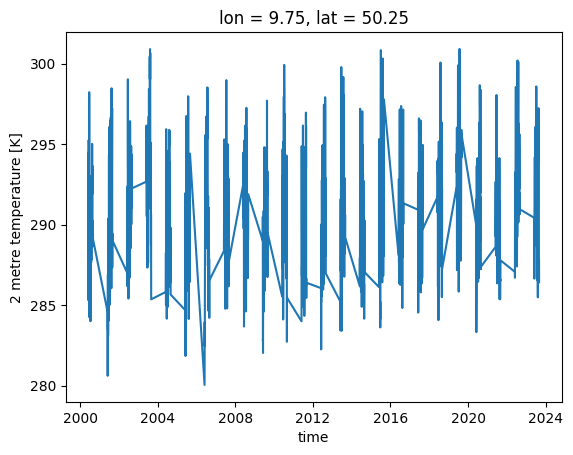

In [131]:
T_summer = T_seasonal['summer']

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


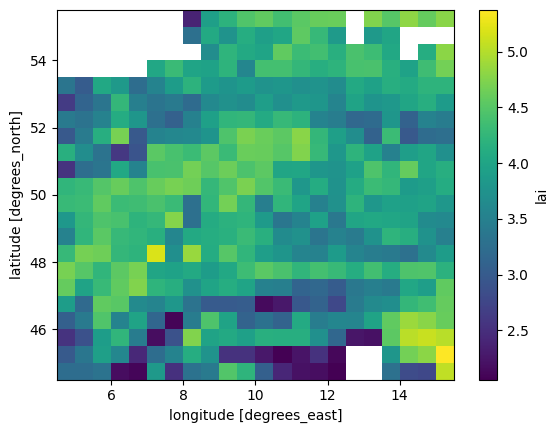

In [143]:
lai_data.max(dim='time').plot()